# <span>Biological Databases</span> <span style="float: right;">Nicolas Roux</span>

## Practical 5 : PSSM

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import product

In [3]:
def to_pssm(profile_matrix, k, prior_probability = 0.25):
    """
        Create the position-specific scoring matrix from a profile matrix
        param: 
            profile_matrix : pandas dataframe containing the biding sites
                format : each column represent a position; each row represent a binding site; each cell represent a nucleotide
            k : float representing the pseudo count
            prior_probability : represent the probability of occurence for each nucleotide. by default the prior probability is 0.25 : each nucleotide has the same probability
                format : float or a dictionary containing the nucleotide and its probability. exemple : {"A":  0.35, "T": 0.35, "G": 0.20, "C": 0.20}
        return : a pandas dataframe
            format : each column represent a position, each row represent a nucleotide, each cell represent a score
    """
    #initialize the dataframe with the count of each base at each position
    n = len(profile_matrix.iloc[1,:])
    pcm_df = pd.DataFrame(np.zeros((4, n)))   #creates a dataframe with 4 rows and 9 columns filled with 0
    pcm_df['nt'] = ['A', 'T', 'C', 'G']       #add a column named nt where each row represent one base A,C,T or G
    pcm_df.set_index('nt', inplace= True)     #put the nt column as an index fo an easier access to each base

    #build the position count dataframe based on pcm_df
    for i in range(pcm_df.shape[1]):
        count = profile_matrix.iloc[:, i].value_counts()  #compute the count of each base
        pcm_df[i] = pcm_df.index.map(count).fillna(0)  #fill the pcm_df with the counts (put 0 if NA)

    #convert the position count matrix (pcm_df) to a position-specific scoring matrix (PSSM) with pseudo-counts
    N = profile_matrix.shape[0]  #get the number of binding sites from the profile_matrix
    if isinstance(prior_probability, float):
        f = (pcm_df + prior_probability*k) / (N + k)
        pssm = np.log(f / prior_probability)
        
    elif isinstance(prior_probability,dict):
        proba_times_k = {key: value*k for key, value in prior_probability.items()}
        f = pcm_df.add(proba_times_k, axis = 0) / (N + k)
        pssm = np.log(f.div(prior_probability, axis = 0))

    return pssm

def pssm_scores(data, gene, pssm):
    """
        compute the scores of all possible sequences in the upstream region of the input gene
        param:
            data : dictionary containing all the genes and their upstream regions
                format: {str(gene_name) : str(upstream_region)}
            gene : string of the gene's name
            pssm : pandas dataframe representing a position-specific scores matrix
        return: a tuple with the gene's name and the scores for all the possible sequences
            format: (str(gene_name), list(scores))
    """
    scores = []
    upstream_seq = data[gene]
    
    #compute the global score for all the possible sequences
    for i in range(len(upstream_seq)-8):
        seq = upstream_seq[i:i+9]
        score = 0

        #compute the global score for a given sequence
        for j, letter in enumerate(seq):
            score += float(pssm.loc[letter, j])      #extract the score of the nucleotide from the pssm
            
        scores.append(score)
        
    return (gene, scores)

def genes_scores(genes_list, data, pssm):
    """
        get the pssm scores for a gene selection
        param:
            genes_list: list of gene's names
            data: dictionary containing all the genes and their upstream regions
                format: {str(gene_name) : str(upstream_region)}
            pssm: pandas dataframe representig the position-specific scores matrix
        return: dictionnary with the scores as a list (value) of each gene (key)
            format: {str(gene_name): list(scores)}
    """

    scores_dict = {}
    #iterate threw the genes to get their scores
    for gene_name in genes_list:
        gene_score = pssm_scores(data = data, gene = gene_name, pssm = pssm) #extract the pssm scores of the gene
        scores_dict[gene_score[0]] = gene_score[1]                           #add the gene to the dictionary

    return scores_dict

def binding_sites(scores_dict, treshold):
    """
        print the predicted binding sites for a gene selection. 
        param:
            scores_dict: dictionnary with the pssm scores as a list (value) of each gene (key)
                format: {str(gene_name): list(scores)}
            treshold: value of the treshold. int or float.
        return: None
    """
    for gene, scores in scores_dict.items():
        i = 0                                     #parameter allowing to retrieve the sequence we are currently looking at
        count = 0                                 #to count if we select at least one binding site
        print(f"\n{gene}:")
    
        for value in scores:
        
            if value > treshold:                  #filter the biding sites by the treshold
                count += 1
                print(f">{upstream_regions_dict[gene][i:i+9]}  |  position (before ORF): {-(999-i)}bp  |  score: {value}")
            
            i += 1
        
        if count == 0 :                           #to explicitly say if we don't find a binding site for one gene
            print(">no possible binding site was found")

def reverse_complement(sequence):
    """
        convert a 5'-3' dna string to his complement.
        param: string of the dna sequence to convert
        return: string of the sequence complement
    """
    reversion = {'A': 'T', 'C': 'G', 'T': 'A', 'G': 'C'}

    seq_list = [reversion[letter] for letter in sequence]
    
    return ''.join(seq_list)

def best_sequence(matrix):
    """
        compute the sequence giving the highest score
    param:
        matrix : pandas dataframe representing the position-specific frequency or scoring matrix
    return: a list of the best sequence.
    """
    
    best_seq = [0 for i in range(matrix.shape[1])]
    
    for i in range(matrix.shape[1]):
        best_score = 0
        best_nt = []
        
        for j in range(4):
            j_score =  matrix.iloc[j][i]
            
            #if the best score is shared by two or more nucleotides
            if j_score == best_score:
                best_nt.append(matrix.index[j])

            #replace by the nucleotide which have the best score
            elif j_score > best_score:
                best_score = j_score
                best_nt = [matrix.index[j]]
                
        best_seq[i] = best_nt
    result = ""
    
    #convert the sequence list to a unique string
    for i in range(len(best_seq)):
        if len(best_seq[i]) > 1:
            result += "("
            position_i = ""
            for j in range(len(best_seq[i])):
                position_i += best_seq[i][j]
            result += position_i+")"
        else: 
            result += best_seq[i][0]
            
    return result

load the upstream regions of the genes stored in the directory named data

In [5]:
#the fasta files containing the gene sequence with the upstream region should be stored in a directory named 'data' in the current working directory
#the reverse complement sequence of the genes should be downloaded like the other files, the code will not build the reverse complement
data_path = Path('data')
file_list = sorted(data_path.glob('*.fsa'))

#store the upstream regions in a dictionnary 
#key = gene name; value = upstream sequence in str
upstream_regions_dict = {}

for file in file_list:
    with open(file) as f:
        gene_name = f.readline().split()[1]                                               #get the gene name ; in the fasta file the gene name is on the first row as the second information
        upstream_sequence = f.read().replace("\n", "")[:1000]                             #store the upstream region (the first 1000bp) in one string
        upstream_regions_dict[gene_name] = upstream_sequence
        gene_name_reverse = gene_name + 'reverse'
        upstream_regions_dict[gene_name_reverse] = reverse_complement(upstream_sequence)  #add the reverse sequence in the dictionary

build the position-specific scores matrix with the pseudo count and the prior probability set to 0.1 and 0.25

In [7]:
#build a pandas dataframe with the MET31 biding sites
position_matrix = np.array([("T", "G", "C", "C", "A", "C", "T", "G", "T"), 
                            ("C", "G", "C", "C", "A", "C", "A", "T", "G"), 
                            ("C", "G", "C", "C", "A", "C", "T", "A", "T"), 
                            ("C", "G", "C", "C", "A", "C", "G", "T", "C"), 
                            ("C", "C", "C", "C", "A", "G", "A", "G", "T"), 
                            ("C", "G", "C", "C", "A", "C", "G", "G", "C"), 
                            ("T", "G", "C", "C", "A", "C", "C", "T", "T"), 
                            ("C", "G", "C", "C", "A", "C", "C", "G", "T"), 
                            ("C", "G", "C", "T", "A", "C", "C", "G", "G"), 
                            ("C", "G", "C", "C", "T", "C", "C", "G", "T"), 
                            ("A", "G", "C", "C", "A", "C", "A", "C", "C"), 
                            ("C", "G", "C", "C", "A", "C", "G", "A", "T"), 
                            ("C", "A", "C", "C", "A", "C", "A", "C", "T"), 
                            ("C", "G", "C", "C", "T", "C", "A", "C", "C"), 
                            ("C", "G", "C", "C", "A", "C", "T", "A", "C"), 
                            ("C", "G", "C", "C", "A", "C", "A", "C", "A"), 
                            ("A", "G", "C", "C", "A", "C", "A", "A", "C"), 
                            ("A", "G", "C", "C", "A", "C", "A", "C", "C"), 
                            ("C", "G", "C", "G", "A", "C", "A", "C", "A"), 
                            ("A", "G", "C", "C", "A", "C", "A", "T", "C")])

position_df = pd.DataFrame(position_matrix)
display(position_df)

,0,1,2,3,4,5,6,7,8
0,T,G,C,C,A,C,T,G,T
1,C,G,C,C,A,C,A,T,G
2,C,G,C,C,A,C,T,A,T
3,C,G,C,C,A,C,G,T,C
4,C,C,C,C,A,G,A,G,T
5,C,G,C,C,A,C,G,G,C
6,T,G,C,C,A,C,C,T,T
7,C,G,C,C,A,C,C,G,T
8,C,G,C,T,A,C,C,G,G
9,C,G,C,C,T,C,C,G,T


In [8]:
#show the position-specific frequency matrix
#initialize the dataframe with the count of each base at each position
n = len(position_df.iloc[1,:])
pcm_df = pd.DataFrame(np.zeros((4, n)))   #creates a dataframe with 4 rows and 9 columns filled with 0
pcm_df['nt'] = ['A', 'T', 'C', 'G']       #add a column named nt where each row represent one base A,C,T or G
pcm_df.set_index('nt', inplace= True)     #put the nt column as an index fo an easier access to each base

#build the position count dataframe based on pcm_df
for i in range(pcm_df.shape[1]):
    count = position_df.iloc[:, i].value_counts()  #compute the count of each base
    pcm_df[i] = pcm_df.index.map(count).fillna(0)  #fill the pcm_df with the counts (put 0 if NA)

#build the position-specific frequency matrix on top of the pcm_df
pfm_df = pcm_df / position_df.shape[0]
display(pfm_df)
print(best_sequence(pfm_df))

,0,1,2,3,4,5,6,7,8
nt,,,,,,,,,
A,0.2,0.05,0.0,0.00,0.9,0.00,0.50,0.2,0.1
T,0.1,0.00,0.0,0.05,0.1,0.00,0.15,0.2,0.4
C,0.7,0.05,1.0,0.90,0.0,0.95,0.20,0.3,0.4
G,0.0,0.90,0.0,0.05,0.0,0.05,0.15,0.3,0.1


CGCCACA(CG)(TC)


As the position 8 and 9 have two nucleotides sharing the best scores, this matrix gives 4 sequences sharing the best scores :

CGCCACACT | CGCCACAGC | CGCCACACC | CGCCACAGT

In yeastgenome.org we can find a PFM matrix provided by [YeTFaSCo](http://yetfasco.ccbr.utoronto.ca/showPFM.php?mot=YPL038W_1370.0)

In [11]:
dict_yetfasco = {"A" : [0.226264203115247, 0.000997008973080758, 0.909158571337586, 0.000972774944093644, 0.658539553893394, 0.195681620887396, 0.148911227386004, 0.11386459774289],
"T" : [0.000559131444753055, 0.000997008973080773, 0.0330853666640066, 0.0252795060181707, 0.201248728514209, 0.10275493792513, 0.58568601372582, 0.18873709611146],
"G" : [0.214045220686948, 0.000997008973080758, 0.0396341294150379, 0.000972774944093643, 0.0269526793563805, 0.447611869401167, 0.0105654948617187, 0.601264371929337],
"C" : [0.559131444753053, 0.997008973080758, 0.0181219325833691, 0.972774944093642, 0.113259038236016, 0.253951571786307, 0.254837264026458, 0.096133934216313]}

pfm_yetfasco = pd.DataFrame(dict_yetfasco).T #.T to transpose the df, pandas reads the key of a dictionnary as the column names
display(pfm_yetfasco)

#show the sequence with the best score according to the yetfasco pfm 
print(best_sequence(pfm_yetfasco))

,0,1,2,3,4,5,6,7
A,0.226264,0.000997,0.909159,0.000973,0.658540,0.195682,0.148911,0.113865
T,0.000559,0.000997,0.033085,0.025280,0.201249,0.102755,0.585686,0.188737
G,0.214045,0.000997,0.039634,0.000973,0.026953,0.447612,0.010565,0.601264
C,0.559131,0.997009,0.018122,0.972775,0.113259,0.253952,0.254837,0.096134


CCACAGTG


Its best sequence is CCACAGTG which only differs by one nucleotide with one of the best sequences of our PFM (CGCCACAGT)

In [Jaspar](https://jaspar.elixir.no/matrix/MA0333.1/?revcomp=0), we also find a frequency matrix

In [14]:
dict_jaspar = {"A" :  [38, 20, 14, 0, 0, 0, 0, 0, 10],
               "T" : [15, 20, 55, 0, 100, 0, 0, 0, 20],
               "C" : [10, 28, 14, 0, 0, 0, 0, 100, 0],
               "G" : [38, 30, 18, 100, 0, 100, 100, 0, 69]
}

pfm_jaspar = pd.DataFrame(dict_jaspar).T      #.T to transpose the df, pandas reads the key of a dictionnary as the column names
display(pfm_jaspar/100)
print(best_sequence(pfm_jaspar))

,0,1,2,3,4,5,6,7,8
A,0.38,0.20,0.14,0.0,0.0,0.0,0.0,0.0,0.10
T,0.15,0.20,0.55,0.0,1.0,0.0,0.0,0.0,0.20
C,0.10,0.28,0.14,0.0,0.0,0.0,0.0,1.0,0.00
G,0.38,0.30,0.18,1.0,0.0,1.0,1.0,0.0,0.69


(AG)GTGTGGCG


the jaspar matrix gives us two best sequences :

AGTGTGGCG | GGTGTGGCG

This matrix gives us two very different sequences compared to our PFM and to the yetfasco PFM.

# Sequence scanning with the PSSM.

First the pssm will be build with a pseudo count of 0.1 and a prior probability of 0.25 (The 4 nucleotides have the same probability to occur)

k=0.1, prior_probability=0.25

In [18]:
pssm_df = to_pssm(position_df, k = 0.1)
display(pssm_df)

#get the scores of all the possible binding sites for the genes known to be regulated by MET31
known_genes_list = ['MET2', 'MET5', 'MET6', 'MET16', 'CYS3', 'SAM1reverse', 'STR3']
known_scores_dict = genes_scores(genes_list = known_genes_list,
                                 data = upstream_regions_dict,
                                 pssm = pssm_df)

,0,1,2,3,4,5,6,7,8
nt,,,,,,,,,
A,-0.221901,-1.589733,-5.303305,-5.303305,1.277334,-5.303305,0.690657,-0.221901,-0.908856
T,-0.908856,-5.303305,-5.303305,-1.589733,-0.908856,-5.303305,-0.507514,-0.221901,0.468136
C,1.026416,-1.589733,1.382556,1.277334,-5.303305,1.331328,-0.221901,0.181492,0.468136
G,-5.303305,1.277334,-5.303305,-1.589733,-5.303305,-1.589733,-0.507514,0.181492,-0.908856


visualize all the pssm scores for the known regulated genes for MET31

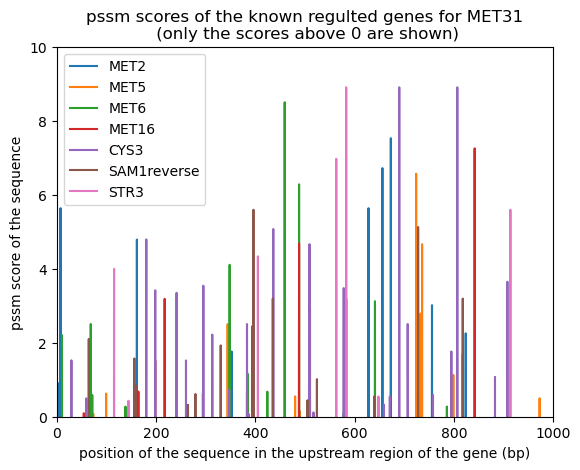

In [20]:
for gene in known_scores_dict:
    plt.plot(known_scores_dict[gene],label = gene)
    plt.axis([0, 1000, 0, 10])
    plt.title('pssm scores of the known regulted genes for MET31\n (only the scores above 0 are shown)')
    plt.xlabel('position of the sequence in the upstream region of the gene (bp)')
    plt.ylabel('pssm score of the sequence')
    plt.legend()
plt.show()

as wee see in the previous graphic, the sequences with the best pssm score are above 6 when the pssm scores are computed with a pseudo-count of 0.1 and a prior-probability set to 0.25 for the 4 types of nucleotide.
So we can set the treshold value at 6 to select the best sequences of each gene.

In [22]:
treshold = 6
binding_sites(known_scores_dict, treshold)


MET2:
>CGCCTCACT  |  position (before ORF): -343bp  |  score: 6.726397951090636
>CGCCACACA  |  position (before ORF): -326bp  |  score: 7.5355959652455695

MET5:
>TGCCACAAT  |  position (before ORF): -275bp  |  score: 6.573923614346697

MET6:
>CGCCACATC  |  position (before ORF): -540bp  |  score: 8.509195365196955
>AGCCACAGG  |  position (before ORF): -511bp  |  score: 6.287279424707336

MET16:
>AGCCACAAC  |  position (before ORF): -157bp  |  score: 7.260878824658722

CYS3:
>CGCCACACT  |  position (before ORF): -309bp  |  score: 8.912587933703147
>CGCCACACT  |  position (before ORF): -192bp  |  score: 8.912587933703147

SAM1reverse:
>no possible binding site was found

STR3:
>TGCCACACT  |  position (before ORF): -436bp  |  score: 6.9773161828528885
>CGCCACAGT  |  position (before ORF): -416bp  |  score: 8.912587933703147


With these parameters there are 10 matches. Among these matches there are 7 True positives out of 8, 3 False positive and 1 False negative (the  biding site on the upstream region of SAM1 is not detected).

The sensitivity (# True positives / T; T = total of sites = True positive/False negative) is 0.875 (87.5%).
The selectivity (# True positives / H; H = total of hits) is  0.7 (70%).

The sensitivity can be improved by lowering the treshold value and find the missing biding site but it will increase the total number of False positive lowering the selectivity. Instead, we can set the tresholdvalue near the lowest score among the True positive to reduce the total of False positive. This score corresponds to the biding site of the gene MET5 : 6.573. we can try now to set the treshold value to 6.5  

With a treshold of 5

In [25]:
treshold = 5
binding_sites(known_scores_dict, treshold)


MET2:
>CACCACAAT  |  position (before ORF): -992bp  |  score: 5.642128294616313
>CCCCACATT  |  position (before ORF): -371bp  |  score: 5.642128294616313
>CGCCTCACT  |  position (before ORF): -343bp  |  score: 6.726397951090636
>CGCCACACA  |  position (before ORF): -326bp  |  score: 7.5355959652455695

MET5:
>TGCCACAAT  |  position (before ORF): -275bp  |  score: 6.573923614346697

MET6:
>CGCCACATC  |  position (before ORF): -540bp  |  score: 8.509195365196955
>AGCCACAGG  |  position (before ORF): -511bp  |  score: 6.287279424707336

MET16:
>AGCCACAAC  |  position (before ORF): -157bp  |  score: 7.260878824658722

CYS3:
>CGCCAGCGC  |  position (before ORF): -563bp  |  score: 5.078969580223662
>CGCCACACT  |  position (before ORF): -309bp  |  score: 8.912587933703147
>CGCCACACT  |  position (before ORF): -192bp  |  score: 8.912587933703147

SAM1reverse:
>TGCCACAGG  |  position (before ORF): -603bp  |  score: 5.600324214395311
>CACCACCGC  |  position (before ORF): -271bp  |  score: 5.132

Here the number of True positives is 8 out of 8 so the sensitivity equals to 100%. However there are 8 False positive out of 16 matches, leading to a drop of 
the selectivity (50%). 

In [27]:
treshold = 6.5
binding_sites(known_scores_dict, treshold)


MET2:
>CGCCTCACT  |  position (before ORF): -343bp  |  score: 6.726397951090636
>CGCCACACA  |  position (before ORF): -326bp  |  score: 7.5355959652455695

MET5:
>TGCCACAAT  |  position (before ORF): -275bp  |  score: 6.573923614346697

MET6:
>CGCCACATC  |  position (before ORF): -540bp  |  score: 8.509195365196955

MET16:
>AGCCACAAC  |  position (before ORF): -157bp  |  score: 7.260878824658722

CYS3:
>CGCCACACT  |  position (before ORF): -309bp  |  score: 8.912587933703147
>CGCCACACT  |  position (before ORF): -192bp  |  score: 8.912587933703147

SAM1reverse:
>no possible binding site was found

STR3:
>TGCCACACT  |  position (before ORF): -436bp  |  score: 6.9773161828528885
>CGCCACAGT  |  position (before ORF): -416bp  |  score: 8.912587933703147


With a treshold of 6.5 the sensitivity stays at 87.5% and the selectivity increase to 77.77%. Which is slightly better than a treshold of 6.

To improve the sensitivity without lowering the selectivity we can change the prior probability and the pseudo count values.

In [29]:
##the pseudo count value k is changed to 1

pssm_df2 = to_pssm(position_df, k = 1)

known_scores_dict2 = genes_scores(genes_list = known_genes_list,
                                 data = upstream_regions_dict,
                                 pssm = pssm_df)

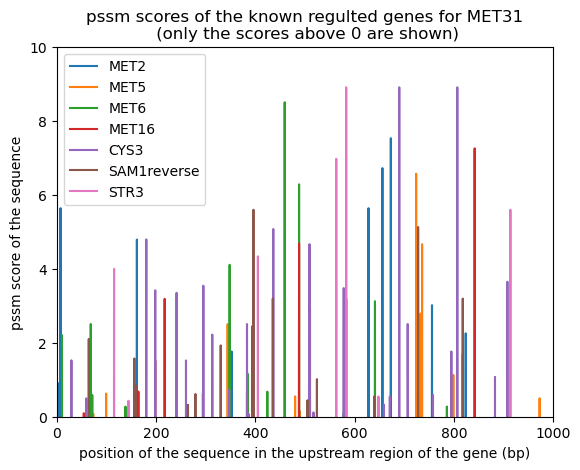

In [30]:
#visualize the scores of the sequences among the genes

for gene in known_scores_dict2:
    plt.plot(known_scores_dict2[gene],label = gene)
    plt.axis([0, 1000, 0, 10])
    plt.title('pssm scores of the known regulted genes for MET31\n (only the scores above 0 are shown)')
    plt.xlabel('position of the sequence in the upstream region of the gene (bp)')
    plt.ylabel('pssm score of the sequence')
    plt.legend()
plt.show()

The graphic looks pretty similar to the previous one with a k set to 0.1.
Therefore, the treshold remains at 6.5

In [32]:
treshold2 = 6.5

binding_sites(known_scores_dict2, treshold2)


MET2:
>CGCCTCACT  |  position (before ORF): -343bp  |  score: 6.726397951090636
>CGCCACACA  |  position (before ORF): -326bp  |  score: 7.5355959652455695

MET5:
>TGCCACAAT  |  position (before ORF): -275bp  |  score: 6.573923614346697

MET6:
>CGCCACATC  |  position (before ORF): -540bp  |  score: 8.509195365196955

MET16:
>AGCCACAAC  |  position (before ORF): -157bp  |  score: 7.260878824658722

CYS3:
>CGCCACACT  |  position (before ORF): -309bp  |  score: 8.912587933703147
>CGCCACACT  |  position (before ORF): -192bp  |  score: 8.912587933703147

SAM1reverse:
>no possible binding site was found

STR3:
>TGCCACACT  |  position (before ORF): -436bp  |  score: 6.9773161828528885
>CGCCACAGT  |  position (before ORF): -416bp  |  score: 8.912587933703147


By setting the k to 1, the sensitivity and the selectivity remain exactly the same.

By default we setted the prior probability at 0.25 for the different nucleotides. We assumed that the probability of the occurence of one nucleotide at a given position, is the same as the probability of the other nucleotides. 

This statement is a simplification of the reality and is therefore is not true. In the yeast genome as all the other genomes, the four types of nucleotide are not equally represented. In [NCBI](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000146045.2/), we can see that the GC content is equal to 38.5%.
So the probabilities for A, C, G and T are computed like this:
$$
\begin{aligned}
P(G) = P(C) &=  \frac{0.385}{2} = \mathbf{0.1925}\\[1em]
P(A) = P(T) &= \frac{1 - 0.385}{2} = \mathbf{0.3075} \\
\quad
\end{aligned}
$$

In [35]:
prior_probabilities = {"A":  0.3075, "T": 0.3075, "G": 0.1925, "C": 0.1925}
pssm_df3 = to_pssm(position_df, k = 1, prior_probability = prior_probabilities)
display(pssm_df3)

#get the scores of all the possible binding sites for the genes known to be regulated by MET31
known_genes_list = ['MET2', 'MET5', 'MET6', 'MET16', 'CYS3', 'SAM1reverse', 'STR3']
known_scores_dict3 = genes_scores(genes_list = known_genes_list,
                                 data = upstream_regions_dict,
                                 pssm = pssm_df3)

,0,1,2,3,4,5,6,7,8
nt,,,,,,,,,
A,-0.404885,-1.597125,-3.044522,-3.044522,1.042069,-3.044522,0.467630,-0.404885,-1.029078
T,-1.029078,-3.044522,-3.044522,-1.597125,-1.029078,-3.044522,-0.669050,-0.404885,0.251916
C,1.255850,-1.220811,1.608448,1.504146,-3.044522,1.557656,0.036434,0.426476,0.706356
G,-3.044522,1.504146,-3.044522,-1.220811,-3.044522,-1.220811,-0.236059,0.426476,-0.611821


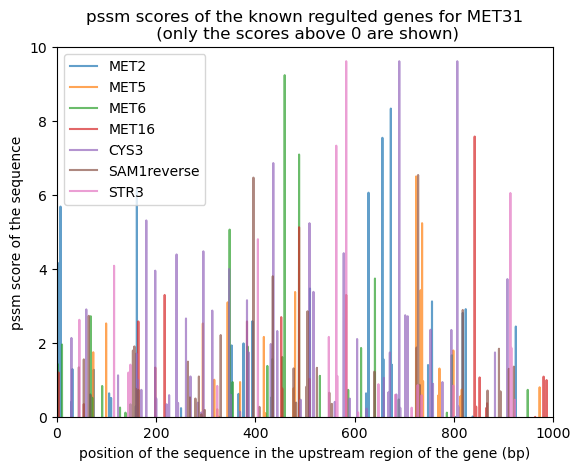

In [36]:
#visualize the scores of the sequences among the genes

for gene in known_scores_dict3:
    plt.plot(known_scores_dict3[gene],label = gene, alpha=0.7)
    plt.axis([0, 1000, 0, 10])
    plt.title('pssm scores of the known regulted genes for MET31\n (only the scores above 0 are shown)')
    plt.xlabel('position of the sequence in the upstream region of the gene (bp)')
    plt.ylabel('pssm score of the sequence')
    plt.legend()
plt.show()

To get the sequence of SAM1reverse and MET5 (in brown and in orange in the graph above) with the highest score, the treshold must be at least 6.

In [38]:
treshold3 = 6

binding_sites(known_scores_dict3, treshold3)


MET2:
>CGCCAGGCT  |  position (before ORF): -838bp  |  score: 6.13618073590167
>CCCCACATT  |  position (before ORF): -371bp  |  score: 6.062019309057947
>CGCCTCACT  |  position (before ORF): -343bp  |  score: 7.5471907884386376
>CGCCACACA  |  position (before ORF): -326bp  |  score: 8.337342879145112

MET5:
>TGCCACAAT  |  position (before ORF): -275bp  |  score: 6.502048884330083

MET6:
>CGCCACATC  |  position (before ORF): -540bp  |  score: 9.241416100379645
>AGCCACAGG  |  position (before ORF): -511bp  |  score: 7.093864670371646

MET16:
>AGCCACAAC  |  position (before ORF): -157bp  |  score: 7.580681200218114

CYS3:
>CGCCAGCGC  |  position (before ORF): -563bp  |  score: 6.863112955555294
>CGCCACACT  |  position (before ORF): -309bp  |  score: 9.618336912996854
>CGCCACACT  |  position (before ORF): -192bp  |  score: 9.618336912996854

SAM1reverse:
>TGCCACAGG  |  position (before ORF): -603bp  |  score: 6.469671668346569
>CACCACCGC  |  position (before ORF): -271bp  |  score: 6.5403

Total matches = 16

True positive = 8

False positive = 8

False negative = 0

selectivity = 50%

sensitivity = 100%

the lowest score for a True positive is 6.5.

In [40]:
binding_sites(known_scores_dict3, 6.5)


MET2:
>CGCCTCACT  |  position (before ORF): -343bp  |  score: 7.5471907884386376
>CGCCACACA  |  position (before ORF): -326bp  |  score: 8.337342879145112

MET5:
>TGCCACAAT  |  position (before ORF): -275bp  |  score: 6.502048884330083

MET6:
>CGCCACATC  |  position (before ORF): -540bp  |  score: 9.241416100379645
>AGCCACAGG  |  position (before ORF): -511bp  |  score: 7.093864670371646

MET16:
>AGCCACAAC  |  position (before ORF): -157bp  |  score: 7.580681200218114

CYS3:
>CGCCAGCGC  |  position (before ORF): -563bp  |  score: 6.863112955555294
>CGCCACACT  |  position (before ORF): -309bp  |  score: 9.618336912996854
>CGCCACACT  |  position (before ORF): -192bp  |  score: 9.618336912996854

SAM1reverse:
>CACCACCGC  |  position (before ORF): -271bp  |  score: 6.540309151693955

STR3:
>TGCCACACT  |  position (before ORF): -436bp  |  score: 7.3334090108102465
>CGCCACAGT  |  position (before ORF): -416bp  |  score: 9.618336912996854


Total matches = 12

True positive = 8

False positive = 5

False negative = 0

selectivity = 66.67%

sensitivity = 100%

The lowest treshold to have a sensitivity equal to 100% is 6.5. If the focus is on the selectivity,the lowest treshold to have only True positive is around 7.55 but the selectivity drops to 75%, the genes MET5 and SAM1 will miss.

To choose the treshold value, we can decide depending on the previous results. We can also try to find a more objective value like the p-value.
To do that we can build a list of all the possible dna sequences of 9 nucleotides. A score will be assigned to each of these sequences. 
H0 : the sequence is not a biding site
H1 : the sequence is a biding site
We can set the treshold at 0.05% (0.0005). It means that for given score if this score among all sequences is in the top 0.05% or that its p-value is below 0.0005, it corresponds to a sequence being a biding site.

In [43]:
###this cell can take thew seconds

#create all the possible dna sequences of 9 nt
a = product('ATCG', repeat = 9)
all_seq_list = [''.join(seq) for seq in a]

scores = []
#compute the global score for all the sequences
for i in range(len(all_seq_list)):
    seq = all_seq_list[i]
    score = 0

    #compute the global score for a given sequence
    for j, letter in enumerate(seq):
        score += float(pssm_df3.loc[letter, j])      #extract the score of the nucleotide from the pssm_df3
            
    scores.append(score)

6.839869279057297


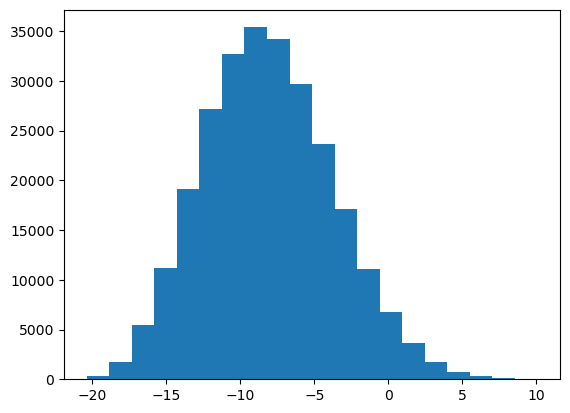

In [44]:
scores = sorted(scores)
scores = scores[::-1]
plt.hist(scores, bins = 20)
alpha = 0.0005
alpha_top_seq = round(len(scores)*alpha)
seuil = scores[alpha_top_seq]
print(seuil)

The treshold can be fixed to 6.8398

# Predictions

In the following cells, 5 genes reported as regulated by MET31 and 5 other genes not know to be regulated by MET31 will be tested with these parameters:
pseudo count = 1
prior probabilities : A = 0.3075, T = 0.3075, G = 0.1925, C = 0.1925
treshold = 7.5 to focus on sensitivity.

In [48]:
prediction_on_known_genes = ['AAR2', 'AAR2reverse', 'CSN9', 'CSN9reverse', 'EGD2','EGD2reverse', 'GLC7','GLC7reverse',  'IES5', 'IES5reverse']
prediction_on_known_genes_dict = genes_scores(genes_list = prediction_on_known_genes,
                                 data = upstream_regions_dict,
                                 pssm = to_pssm(position_df, k= 1, prior_probability = prior_probabilities))
binding_sites(prediction_on_known_genes_dict, treshold = 6.8398)


AAR2:
>no possible binding site was found

AAR2reverse:
>CGCCACAGA  |  position (before ORF): -608bp  |  score: 8.337342879145112

CSN9:
>no possible binding site was found

CSN9reverse:
>no possible binding site was found

EGD2:
>no possible binding site was found

EGD2reverse:
>no possible binding site was found

GLC7:
>no possible binding site was found

GLC7reverse:
>no possible binding site was found

IES5:
>no possible binding site was found

IES5reverse:
>no possible binding site was found


One biding site was find for the gene AAR2 on the reverse complement. The algorithm could not find any binding site on the other genes even if these genes are known to be regulated by MET31, meaning that it is not really effective. Let's now try to see whith genes not known to be regulated. 

In [50]:
not_know_list = ['PRC1', 'PRC1reverse' ,'MLP1', 'MLP1reverse', 'GOT1', 'GOT1reverse', 'ADE4', 'ADE4reverse', 'RPC40', 'RPC40reverse']
not_know_dict = genes_scores(genes_list = not_know_list, 
                             data = upstream_regions_dict, 
                             pssm = to_pssm(position_df, k= 1, prior_probability= prior_probabilities))
binding_sites(not_know_dict, treshold = 6.8398)


PRC1:
>CGCCACCCT  |  position (before ORF): -324bp  |  score: 9.187141275631898

PRC1reverse:
>no possible binding site was found

MLP1:
>CGCCACGTT  |  position (before ORF): -16bp  |  score: 8.083288243361064

MLP1reverse:
>no possible binding site was found

GOT1:
>no possible binding site was found

GOT1reverse:
>no possible binding site was found

ADE4:
>AGCCACCGT  |  position (before ORF): -122bp  |  score: 7.5264063754703665

ADE4reverse:
>CGCCACCAC  |  position (before ORF): -815bp  |  score: 8.810220463014687

RPC40:
>no possible binding site was found

RPC40reverse:
>no possible binding site was found


With genes not known to be regulate, it finds 4 biding sites on the genes PRC1, MLP1, and ADE4.
It founds more biding site with these genes demonstrating that it is not a problem of selectivity but a problem in the model itself. It is possible that i made an error in the implementation that I can't see. With a different profile matrix it could be better. 